# IP-Adapter: Text Compatible Image Prompt Adapter for Text-to-Image Diffusion Model 

**核心**:修改cross attn,在原本text分支上引入image分支
- 提供reference,训练映射层和cross attn层，和原本的text cross attn的输出拼接，引导图像生成

![alt text](../Image/IP-adapter.png)

Variant | Base Class | Projection Model | Image Embedding Source | Compatible With | Special Characteristics
--- | --- | --- | --- | --- | ---
IPAdapter | - | ImageProjModel | CLIP final embeddings | SD 1.5 | Base implementation
IPAdapterPlus | IPAdapter | Resampler | CLIP hidden states[-2] | SD 1.5 | Fine-grained features
IPAdapterXL | IPAdapter | ImageProjModel | CLIP final embeddings | SDXL | SDXL-specific generation
IPAdapterFull | IPAdapterPlus | MLPProjModel | CLIP hidden states[-2] | SD 1.5 | MLP-based projection
IPAdapterPlusXL | IPAdapter | Resampler (XL dims) | CLIP hidden states[-2] | SDXL | Fine-grained features + SDXL compatibility

代码核心实现:IP-Adapter

In [8]:
import torch
class IPAdapter:
    def __init__(self, sd_pipe, image_encoder_path, ip_ckpt, device, num_tokens=4):
        self.device = device
        self.image_encoder_path = image_encoder_path
        self.ip_ckpt = ip_ckpt
        self.num_tokens = num_tokens

        self.pipe = sd_pipe.to(self.device)
        self.set_ip_adapter()

        # load image encoder
        self.image_encoder = CLIPVisionModelWithProjection.from_pretrained(self.image_encoder_path).to(
            self.device, dtype=torch.float16
        )
        self.clip_image_processor = CLIPImageProcessor()
        # image proj model
        self.image_proj_model = self.init_proj()

        self.load_ip_adapter()

    def init_proj(self):
        image_proj_model = ImageProjModel(
            cross_attention_dim=self.pipe.unet.config.cross_attention_dim,
            clip_embeddings_dim=self.image_encoder.config.projection_dim,
            clip_extra_context_tokens=self.num_tokens,
        ).to(self.device, dtype=torch.float16)
        return image_proj_model

    def set_ip_adapter(self):
        unet = self.pipe.unet
        attn_procs = {}
        for name in unet.attn_processors.keys():
            cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
            if name.startswith("mid_block"):
                hidden_size = unet.config.block_out_channels[-1]
            elif name.startswith("up_blocks"):
                block_id = int(name[len("up_blocks.")])
                hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
            elif name.startswith("down_blocks"):
                block_id = int(name[len("down_blocks.")])
                hidden_size = unet.config.block_out_channels[block_id]
            if cross_attention_dim is None:
                attn_procs[name] = AttnProcessor()
            else:
                attn_procs[name] = IPAttnProcessor(
                    hidden_size=hidden_size,
                    cross_attention_dim=cross_attention_dim,
                    scale=1.0,
                    num_tokens=self.num_tokens,
                ).to(self.device, dtype=torch.float16)
        unet.set_attn_processor(attn_procs)
        if hasattr(self.pipe, "controlnet"):
            if isinstance(self.pipe.controlnet, MultiControlNetModel):
                for controlnet in self.pipe.controlnet.nets:
                    controlnet.set_attn_processor(CNAttnProcessor(num_tokens=self.num_tokens))
            else:
                self.pipe.controlnet.set_attn_processor(CNAttnProcessor(num_tokens=self.num_tokens))

    def load_ip_adapter(self):
        if os.path.splitext(self.ip_ckpt)[-1] == ".safetensors":
            state_dict = {"image_proj": {}, "ip_adapter": {}}
            with safe_open(self.ip_ckpt, framework="pt", device="cpu") as f:
                for key in f.keys():
                    if key.startswith("image_proj."):
                        state_dict["image_proj"][key.replace("image_proj.", "")] = f.get_tensor(key)
                    elif key.startswith("ip_adapter."):
                        state_dict["ip_adapter"][key.replace("ip_adapter.", "")] = f.get_tensor(key)
        else:
            state_dict = torch.load(self.ip_ckpt, map_location="cpu")
        self.image_proj_model.load_state_dict(state_dict["image_proj"])
        ip_layers = torch.nn.ModuleList(self.pipe.unet.attn_processors.values())
        ip_layers.load_state_dict(state_dict["ip_adapter"])

    @torch.inference_mode()
    def get_image_embeds(self, pil_image=None, clip_image_embeds=None):
        if pil_image is not None:
            if isinstance(pil_image, Image.Image):
                pil_image = [pil_image]
            clip_image = self.clip_image_processor(images=pil_image, return_tensors="pt").pixel_values
            clip_image_embeds = self.image_encoder(clip_image.to(self.device, dtype=torch.float16)).image_embeds
        else:
            clip_image_embeds = clip_image_embeds.to(self.device, dtype=torch.float16)
        image_prompt_embeds = self.image_proj_model(clip_image_embeds)
        uncond_image_prompt_embeds = self.image_proj_model(torch.zeros_like(clip_image_embeds))
        return image_prompt_embeds, uncond_image_prompt_embeds

    def set_scale(self, scale):
        for attn_processor in self.pipe.unet.attn_processors.values():
            if isinstance(attn_processor, IPAttnProcessor):
                attn_processor.scale = scale

    def generate(
        self,
        pil_image=None,
        clip_image_embeds=None,
        prompt=None,
        negative_prompt=None,
        scale=1.0,
        num_samples=4,
        seed=None,
        guidance_scale=7.5,
        num_inference_steps=30,
        **kwargs,
    ):
        self.set_scale(scale)

        if pil_image is not None:
            num_prompts = 1 if isinstance(pil_image, Image.Image) else len(pil_image)
        else:
            num_prompts = clip_image_embeds.size(0)

        if prompt is None:
            prompt = "best quality, high quality"
        if negative_prompt is None:
            negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"

        if not isinstance(prompt, List):
            prompt = [prompt] * num_prompts
        if not isinstance(negative_prompt, List):
            negative_prompt = [negative_prompt] * num_prompts

        image_prompt_embeds, uncond_image_prompt_embeds = self.get_image_embeds(
            pil_image=pil_image, clip_image_embeds=clip_image_embeds
        )
        bs_embed, seq_len, _ = image_prompt_embeds.shape
        image_prompt_embeds = image_prompt_embeds.repeat(1, num_samples, 1)
        image_prompt_embeds = image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)
        uncond_image_prompt_embeds = uncond_image_prompt_embeds.repeat(1, num_samples, 1)
        uncond_image_prompt_embeds = uncond_image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)

        with torch.inference_mode():
            prompt_embeds_, negative_prompt_embeds_ = self.pipe.encode_prompt(
                prompt,
                device=self.device,
                num_images_per_prompt=num_samples,
                do_classifier_free_guidance=True,
                negative_prompt=negative_prompt,
            )
            prompt_embeds = torch.cat([prompt_embeds_, image_prompt_embeds], dim=1)
            negative_prompt_embeds = torch.cat([negative_prompt_embeds_, uncond_image_prompt_embeds], dim=1)

        generator = get_generator(seed, self.device)

        images = self.pipe(
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
            generator=generator,
            **kwargs,
        ).images

        return images

## Image projection model
代码中设计了三种不同的图像投影模型
- ImageProjModel：基础 IP-Adapter 中使用的简单线性投影模型
- MLPProjModel：在 IP-AdapterFull 中使用多层感知器进行更复杂的投影
- Resampler：在 IP-AdapterPlus 变体中用于细粒度特征提取

In [9]:
import torch
import torch.nn as nn
class ImageProjModel(torch.nn.Module):
    """Projection Model"""

    def __init__(self, cross_attention_dim=1024, clip_embeddings_dim=1024, clip_extra_context_tokens=4):
        super().__init__()

        self.generator = None
        self.cross_attention_dim = cross_attention_dim
        self.clip_extra_context_tokens = clip_extra_context_tokens
        self.proj = torch.nn.Linear(clip_embeddings_dim, self.clip_extra_context_tokens * cross_attention_dim)
        self.norm = torch.nn.LayerNorm(cross_attention_dim)

    def forward(self, image_embeds):
        embeds = image_embeds
        # 使用简单的单线性映射层+LayerNorm
        # -----------------------------------------------
        clip_extra_context_tokens = self.proj(embeds).reshape(
            -1, self.clip_extra_context_tokens, self.cross_attention_dim
        )
        clip_extra_context_tokens = self.norm(clip_extra_context_tokens)
        # -----------------------------------------------
        return clip_extra_context_tokens


In [10]:

class MLPProjModel(torch.nn.Module):
    """SD model with image prompt"""
    def __init__(self, cross_attention_dim=1024, clip_embeddings_dim=1024):
        super().__init__()
        # 使用相对复杂的Linear+GELU+Linear+LayeNorm进行映射
        # ------------------------------------------------
        self.proj = torch.nn.Sequential(
            torch.nn.Linear(clip_embeddings_dim, clip_embeddings_dim),
            torch.nn.GELU(),
            torch.nn.Linear(clip_embeddings_dim, cross_attention_dim),
            torch.nn.LayerNorm(cross_attention_dim)
        )
        
    def forward(self, image_embeds):
        clip_extra_context_tokens = self.proj(image_embeds)
        return clip_extra_context_tokens
    

In [11]:
    
class Resampler(nn.Module):
    def __init__(
        self,
        dim=1024,
        depth=8,
        dim_head=64,
        heads=16,
        num_queries=8,
        embedding_dim=768,
        output_dim=1024,
        ff_mult=4,
        max_seq_len: int = 257,  # CLIP tokens + CLS token
        apply_pos_emb: bool = False,
        num_latents_mean_pooled: int = 0,  # number of latents derived from mean pooled representation of the sequence
    ):
        super().__init__()
        self.pos_emb = nn.Embedding(max_seq_len, embedding_dim) if apply_pos_emb else None

        self.latents = nn.Parameter(torch.randn(1, num_queries, dim) / dim**0.5)

        self.proj_in = nn.Linear(embedding_dim, dim)

        self.proj_out = nn.Linear(dim, output_dim)
        self.norm_out = nn.LayerNorm(output_dim)

        self.to_latents_from_mean_pooled_seq = (
            nn.Sequential(
                nn.LayerNorm(dim),
                nn.Linear(dim, dim * num_latents_mean_pooled),
                Rearrange("b (n d) -> b n d", n=num_latents_mean_pooled),
            )
            if num_latents_mean_pooled > 0
            else None
        )

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(
                nn.ModuleList(
                    [
                        PerceiverAttention(dim=dim, dim_head=dim_head, heads=heads),
                        FeedForward(dim=dim, mult=ff_mult),
                    ]
                )
            )

    def forward(self, x):
        if self.pos_emb is not None:
            n, device = x.shape[1], x.device
            pos_emb = self.pos_emb(torch.arange(n, device=device))
            x = x + pos_emb

        latents = self.latents.repeat(x.size(0), 1, 1)

        x = self.proj_in(x)

        if self.to_latents_from_mean_pooled_seq:
            meanpooled_seq = masked_mean(x, dim=1, mask=torch.ones(x.shape[:2], device=x.device, dtype=torch.bool))
            meanpooled_latents = self.to_latents_from_mean_pooled_seq(meanpooled_seq)
            latents = torch.cat((meanpooled_latents, latents), dim=-2)

        for attn, ff in self.layers:
            latents = attn(x, latents) + latents
            latents = ff(latents) + latents

        latents = self.proj_out(latents)
        return self.norm_out(latents)


## 注意力机制修改
- IPAttnProcessor: 修改交叉注意力以包含图像嵌入
- CNAttnProcessor: 控制网集成的特殊处理器(for control-net layers)
- AttnProcessor: 标准处理器，用于没有交叉注意力的层(for non-cross-attention layers)

IP-adapter类中设置注意力机制的函数——set_ip_adapter()

In [ ]:
def set_ip_adapter(self):
        unet = self.pipe.unet
        attn_procs = {}
        for name in unet.attn_processors.keys():
            # 如果以attn.processor结尾，则说明是self-attn模块，否则说明是cross_attn
            cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
            # 如果是mid_block,则取最后一层
            if name.startswith("mid_block"):
                hidden_size = unet.config.block_out_channels[-1]
            # 如果是
            elif name.startswith("up_blocks"):
                block_id = int(name[len("up_blocks.")])
                hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
            # 如果是down_blocks，则
            elif name.startswith("down_blocks"):
                block_id = int(name[len("down_blocks.")])
                hidden_size = unet.config.block_out_channels[block_id]
            if cross_attention_dim is None:
                attn_procs[name] = AttnProcessor()
            else:
                attn_procs[name] = IPAttnProcessor(
                    hidden_size=hidden_size,
                    cross_attention_dim=cross_attention_dim,
                    scale=1.0,
                    num_tokens=self.num_tokens,
                ).to(self.device, dtype=torch.float16)
        unet.set_attn_processor(attn_procs)
        if hasattr(self.pipe, "controlnet"):
            if isinstance(self.pipe.controlnet, MultiControlNetModel):
                for controlnet in self.pipe.controlnet.nets:
                    controlnet.set_attn_processor(CNAttnProcessor(num_tokens=self.num_tokens))
            else:
                self.pipe.controlnet.set_attn_processor(CNAttnProcessor(num_tokens=self.num_tokens))

### IPAttnProcessor
- encoder hidden state:文本隐藏状态
- ip hidden state：图像隐藏状态
- 加权组合：`hidden_states = hidden_states + self.scale * ip_hidden_states`
- linear proj + dropout

In [ ]:
class IPAttnProcessor(nn.Module):
    r"""
    Attention processor for IP-Adapater.
    Args:
        hidden_size (`int`):
            The hidden size of the attention layer.
        cross_attention_dim (`int`):
            The number of channels in the `encoder_hidden_states`.
        scale (`float`, defaults to 1.0):
            the weight scale of image prompt.
        num_tokens (`int`, defaults to 4 when do ip_adapter_plus it should be 16):
            The context length of the image features.
    """

    def __init__(self, hidden_size, cross_attention_dim=None, scale=1.0, num_tokens=4):
        super().__init__()

        self.hidden_size = hidden_size
        self.cross_attention_dim = cross_attention_dim
        self.scale = scale
        self.num_tokens = num_tokens

        self.to_k_ip = nn.Linear(cross_attention_dim or hidden_size, hidden_size, bias=False)
        self.to_v_ip = nn.Linear(cross_attention_dim or hidden_size, hidden_size, bias=False)

    def __call__(
        self,
        attn,
        hidden_states,
        encoder_hidden_states=None,
        attention_mask=None,
        temb=None,
        *args,
        **kwargs,
    ):
        residual = hidden_states

        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        else:
            # get encoder_hidden_states, ip_hidden_states
            end_pos = encoder_hidden_states.shape[1] - self.num_tokens
            encoder_hidden_states, ip_hidden_states = (
                encoder_hidden_states[:, :end_pos, :],
                encoder_hidden_states[:, end_pos:, :],
            )
            if attn.norm_cross:
                encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)
        # 计算普通注意力
        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attention_probs = attn.get_attention_scores(query, key, attention_mask)
        hidden_states = torch.bmm(attention_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)

        # 计算图像提示注意力
        ip_key = self.to_k_ip(ip_hidden_states)
        ip_value = self.to_v_ip(ip_hidden_states)

        ip_key = attn.head_to_batch_dim(ip_key)
        ip_value = attn.head_to_batch_dim(ip_value)

        ip_attention_probs = attn.get_attention_scores(query, ip_key, None)
        self.attn_map = ip_attention_probs
        ip_hidden_states = torch.bmm(ip_attention_probs, ip_value)
        ip_hidden_states = attn.batch_to_head_dim(ip_hidden_states)

        # 加权组合
        # --------------------------------------------------------------
        hidden_states = hidden_states + self.scale * ip_hidden_states
        # --------------------------------------------------------------

        
        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states


### CNAttnProcessor

In [1]:
class CNAttnProcessor:
    r"""
    Default processor for performing attention-related computations.
    """

    def __init__(self, num_tokens=4):
        self.num_tokens = num_tokens

    def __call__(self, attn, hidden_states, encoder_hidden_states=None, attention_mask=None, temb=None, *args, **kwargs,):
        residual = hidden_states

        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        else:
            end_pos = encoder_hidden_states.shape[1] - self.num_tokens
            encoder_hidden_states = encoder_hidden_states[:, :end_pos]  # only use text
            if attn.norm_cross:
                encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attention_probs = attn.get_attention_scores(query, key, attention_mask)
        hidden_states = torch.bmm(attention_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states

## IPAdapterFaceID
- IPAdapterFaceID
- IPAdapterFaceIDPlus
- IPAdapterFaceIDXL
- IPAdapterFaceIDPlusXL

In [2]:
import torch
class IPAdapterFaceID:
    def __init__(self, sd_pipe, ip_ckpt, device, lora_rank=128, num_tokens=4, torch_dtype=torch.float16):
        self.device = device
        self.ip_ckpt = ip_ckpt
        self.lora_rank = lora_rank
        self.num_tokens = num_tokens
        self.torch_dtype = torch_dtype

        self.pipe = sd_pipe.to(self.device)
        self.set_ip_adapter()

        # image proj model
        self.image_proj_model = self.init_proj()

        self.load_ip_adapter()

    def init_proj(self):
        image_proj_model = MLPProjModel(
            cross_attention_dim=self.pipe.unet.config.cross_attention_dim,
            id_embeddings_dim=512,
            num_tokens=self.num_tokens,
        ).to(self.device, dtype=self.torch_dtype)
        return image_proj_model

    def set_ip_adapter(self):
        unet = self.pipe.unet
        attn_procs = {}
        for name in unet.attn_processors.keys():
            cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
            if name.startswith("mid_block"):
                hidden_size = unet.config.block_out_channels[-1]
            elif name.startswith("up_blocks"):
                block_id = int(name[len("up_blocks.")])
                hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
            elif name.startswith("down_blocks"):
                block_id = int(name[len("down_blocks.")])
                hidden_size = unet.config.block_out_channels[block_id]
            if cross_attention_dim is None:
                attn_procs[name] = LoRAAttnProcessor(
                    hidden_size=hidden_size, cross_attention_dim=cross_attention_dim, rank=self.lora_rank,
                ).to(self.device, dtype=self.torch_dtype)
            else:
                attn_procs[name] = LoRAIPAttnProcessor(
                    hidden_size=hidden_size, cross_attention_dim=cross_attention_dim, scale=1.0, rank=self.lora_rank, num_tokens=self.num_tokens,
                ).to(self.device, dtype=self.torch_dtype)
        unet.set_attn_processor(attn_procs)

    def load_ip_adapter(self):
        if os.path.splitext(self.ip_ckpt)[-1] == ".safetensors":
            state_dict = {"image_proj": {}, "ip_adapter": {}}
            with safe_open(self.ip_ckpt, framework="pt", device="cpu") as f:
                for key in f.keys():
                    if key.startswith("image_proj."):
                        state_dict["image_proj"][key.replace("image_proj.", "")] = f.get_tensor(key)
                    elif key.startswith("ip_adapter."):
                        state_dict["ip_adapter"][key.replace("ip_adapter.", "")] = f.get_tensor(key)
        else:
            state_dict = torch.load(self.ip_ckpt, map_location="cpu")
        self.image_proj_model.load_state_dict(state_dict["image_proj"])
        ip_layers = torch.nn.ModuleList(self.pipe.unet.attn_processors.values())
        ip_layers.load_state_dict(state_dict["ip_adapter"])

    @torch.inference_mode()
    def get_image_embeds(self, faceid_embeds):
        
        faceid_embeds = faceid_embeds.to(self.device, dtype=self.torch_dtype)
        image_prompt_embeds = self.image_proj_model(faceid_embeds)
        uncond_image_prompt_embeds = self.image_proj_model(torch.zeros_like(faceid_embeds))
        return image_prompt_embeds, uncond_image_prompt_embeds

    def set_scale(self, scale):
        for attn_processor in self.pipe.unet.attn_processors.values():
            # 使用lora合并
            if isinstance(attn_processor, LoRAIPAttnProcessor):
                attn_processor.scale = scale

    def generate(
        self,
        faceid_embeds=None,
        prompt=None,
        negative_prompt=None,
        scale=1.0,
        num_samples=4,
        seed=None,
        guidance_scale=7.5,
        num_inference_steps=30,
        **kwargs,
    ):
        self.set_scale(scale)

       
        num_prompts = faceid_embeds.size(0)
            negative_prompt = [negative_prompt] * num_prompts

        image_prompt_embeds, uncond_image_prompt_embeds = self.get_image_embeds(faceid_embeds)

        bs_embed, seq_len, _ = image_prompt_embeds.shape
        image_prompt_embeds = image_prompt_embeds.repeat(1, num_samples, 1)
        image_prompt_embeds = image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)
        uncond_image_prompt_embeds = uncond_image_prompt_embeds.repeat(1, num_samples, 1)
        if not isinstance(negative_prompt, List):
            negative_prompt = [negative_prompt] * num_prompts
        # 获得cond和uncond的embed
        image_prompt_embeds, uncond_image_prompt_embeds = self.get_image_embeds(faceid_embeds)
        # batch_size,seq_len,_
        bs_embed, seq_len, _ = image_prompt_embeds.shape
        image_prompt_embeds = image_prompt_embeds.repeat(1, num_samples, 1)
        image_prompt_embeds = image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)
        uncond_image_prompt_embeds = uncond_image_prompt_embeds.repeat(1, num_samples, 1)
        uncond_image_prompt_embeds = uncond_image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)

        with torch.inference_mode():
            prompt_embeds_, negative_prompt_embeds_ = self.pipe.encode_prompt(
                prompt,
                device=self.device,
                num_images_per_prompt=num_samples,
                do_classifier_free_guidance=True,
                negative_prompt=negative_prompt,
            )
            prompt_embeds = torch.cat([prompt_embeds_, image_prompt_embeds], dim=1)
            negative_prompt_embeds = torch.cat([negative_prompt_embeds_, uncond_image_prompt_embeds], dim=1)

        generator = get_generator(seed, self.device)

        images = self.pipe(
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
            generator=generator,
            **kwargs,
        ).images

        return images



### LoRAAttnProcessor

In [4]:
# modified from https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/attention_processor.py
import torch
import torch.nn as nn
import torch.nn.functional as F

from diffusers.models.lora import LoRALinearLayer


class LoRAAttnProcessor(nn.Module):
    r"""
    Default processor for performing attention-related computations.
    """

    def __init__(
        self,
        hidden_size=None,
        cross_attention_dim=None,
        rank=4,
        network_alpha=None,
        lora_scale=1.0,
    ):
        super().__init__()

        self.rank = rank
        self.lora_scale = lora_scale
        
        self.to_q_lora = LoRALinearLayer(hidden_size, hidden_size, rank, network_alpha)
        self.to_k_lora = LoRALinearLayer(cross_attention_dim or hidden_size, hidden_size, rank, network_alpha)
        self.to_v_lora = LoRALinearLayer(cross_attention_dim or hidden_size, hidden_size, rank, network_alpha)
        self.to_out_lora = LoRALinearLayer(hidden_size, hidden_size, rank, network_alpha)

    def __call__(
        self,
        attn,
        hidden_states,
        encoder_hidden_states=None,
        attention_mask=None,
        temb=None,
        *args,
        **kwargs,
    ):
        residual = hidden_states

        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states) + self.lora_scale * self.to_q_lora(hidden_states)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        elif attn.norm_cross:
            encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        key = attn.to_k(encoder_hidden_states) + self.lora_scale * self.to_k_lora(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states) + self.lora_scale * self.to_v_lora(encoder_hidden_states)

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attention_probs = attn.get_attention_scores(query, key, attention_mask)
        hidden_states = torch.bmm(attention_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states) + self.lora_scale * self.to_out_lora(hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states


class LoRAIPAttnProcessor(nn.Module):
    r"""
    Attention processor for IP-Adapater.
    Args:
        hidden_size (`int`):
            The hidden size of the attention layer.
        cross_attention_dim (`int`):
            The number of channels in the `encoder_hidden_states`.
        scale (`float`, defaults to 1.0):
            the weight scale of image prompt.
        num_tokens (`int`, defaults to 4 when do ip_adapter_plus it should be 16):
            The context length of the image features.
    """

    def __init__(self, hidden_size, cross_attention_dim=None, rank=4, network_alpha=None, lora_scale=1.0, scale=1.0, num_tokens=4):
        super().__init__()
        self.hidden_size = hidden_size
        self.cross_attention_dim = cross_attention_dim
        self.scale = scale
        self.num_tokens = num_tokens

        self.to_k_ip = nn.Linear(cross_attention_dim or hidden_size, hidden_size, bias=False)
        self.to_v_ip = nn.Linear(cross_attention_dim or hidden_size, hidden_size, bias=False)


        self.hidden_size = hidden_size
        self.cross_attention_dim = cross_attention_dim
        self.scale = scale
        self.num_tokens = num_tokens
        # -----------------------------------------------------------------------------
        self.to_k_ip = nn.Linear(cross_attention_dim or hidden_size, hidden_size, bias=False)
        self.to_v_ip = nn.Linear(cross_attention_dim or hidden_size, hidden_size, bias=False)
        # -----------------------------------------------------------------------------

    def __call__(
        self,
        attn,
        hidden_states,
        encoder_hidden_states=None,
        attention_mask=None,
        temb=None,
        *args,
        **kwargs,
    ):
        residual = hidden_states

        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states) + self.lora_scale * self.to_q_lora(hidden_states)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        else:
            # get encoder_hidden_states, ip_hidden_states
            end_pos = encoder_hidden_states.shape[1] - self.num_tokens
            encoder_hidden_states, ip_hidden_states = (
                encoder_hidden_states[:, :end_pos, :],
                encoder_hidden_states[:, end_pos:, :],
            )
            if attn.norm_cross:
                encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)
        # LoRA注意力：原始权重 + 低秩适应矩阵
        # --------------------------------------------------------------------------------------------------
        key = attn.to_k(encoder_hidden_states) + self.lora_scale * self.to_k_lora(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states) + self.lora_scale * self.to_v_lora(encoder_hidden_states)
        # -------------------------------------------------------------------------------------------------

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attention_probs = attn.get_attention_scores(query, key, attention_mask)
        hidden_states = torch.bmm(attention_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)

        # for ip-adapter
        ip_key = self.to_k_ip(ip_hidden_states)
        ip_value = self.to_v_ip(ip_hidden_states)

        ip_key = attn.head_to_batch_dim(ip_key)
        ip_value = attn.head_to_batch_dim(ip_value)

        ip_attention_probs = attn.get_attention_scores(query, ip_key, None)
        self.attn_map = ip_attention_probs
        ip_hidden_states = torch.bmm(ip_attention_probs, ip_value)
        ip_hidden_states = attn.batch_to_head_dim(ip_hidden_states)

        hidden_states = hidden_states + self.scale * ip_hidden_states

        # linear proj
        hidden_states = attn.to_out[0](hidden_states) + self.lora_scale * self.to_out_lora(hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states



想要自己训练一下，但是训练资源不太允许~~
- Standard IP-Adapter: 16GB+ VRAM GPU
- IP-Adapter Plus: 24GB+ VRAM GPU
- IP-Adapter SDXL: 32GB+ VRAM GPU


## 训练与推理
### 训练
我们仅优化 IP-Adapter，同时保持预训练扩散模型的参数不变。IP-Adapter 在带有一对多图像-文本对的数据集上进行训练，使用与原始 SD 相同的目标函数：

$$
L_{\text{simple}} = \mathbb{E}_{\boldsymbol{x}_0, \epsilon, c_t, c_i} \|\epsilon - \epsilon_{\theta}\bigl(\boldsymbol{x}_t, c_t, c_i, t\bigr)\|^2.
$$

为了在推理阶段实现无条件引导，我们在训练阶段随机丢弃图像条件：

$$
\hat{\epsilon}_{\theta}\bigl(\boldsymbol{x}_t, c_t, c_i, t\bigr) = w \epsilon_{\theta}\bigl(\boldsymbol{x}_t, c_t, c_i, t\bigr) + (1 - w) \epsilon_{\theta}\bigl(\boldsymbol{x}_t, t\bigr)
$$

丢弃时，我们直接将 CLIP 图像嵌入置零。

### 推理
由于文本交叉注意力和图像交叉注意力是分开计算的，我们在推理阶段可以调整图像条件的权重：

$$
\boldsymbol{Z}^{\text{new}} = \text{Attention}(\boldsymbol{Q}, \boldsymbol{K}, \boldsymbol{V}) + \lambda \cdot \text{Attention}(\boldsymbol{Q}, \boldsymbol{K'}, \boldsymbol{V'})
$$

其中，$\lambda$ 是权重因子。当 $\lambda = 0$ 时，模型还原为原始的文本到图像扩散模型(only text-guide)。
```

# Diffusers usage example

## 1.extract face ID embedding

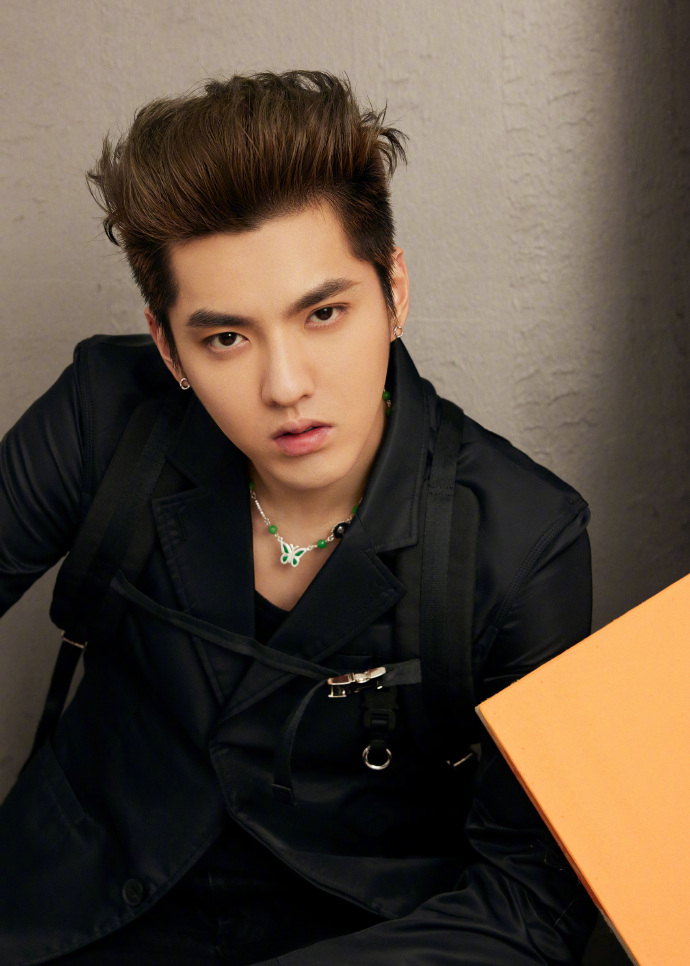

In [15]:
from PIL import Image
image=Image.open(r'C:\Users\Lenovo\Desktop\Paper-recover\Image\kriswu.jpg')
image

In [16]:
import cv2
from insightface.app import FaceAnalysis
import torch

app = FaceAnalysis(name="buffalo_l", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

image = cv2.imread(r"C:\Users\Lenovo\Desktop\Paper-recover\Image\women_input.png")
faces = app.get(image)

faceid_embeds = torch.from_numpy(faces[0].normed_embedding).unsqueeze(0)


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'device_id': '0', 'has_user_compute_stream': '0', 'cudnn_conv1d_pad_to_nc1d': '0', 'user_compute_stream': '0', 'gpu_external_alloc': '0', 'gpu_mem_limit': '18446744073709551615', 'enable_cuda_graph': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'do_copy_in_default_stream': '1', 'cudnn_conv_use_max_workspace': '1', 'tunable_op_enable': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'prefer_nhwc': '0', 'use_ep_level_unified_stream': '0', 'use_tf32': '1', 'sdpa_kernel': '0', 'fuse_conv_bias': '0'}, 'CPUExecutionProvider': {}}
find model: C:\Users\Lenovo/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider

e:\conda_data\envs\heavy_daily\lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


## 2.generate images conditioned on the face embeddings

In [ ]:

import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler, AutoencoderKL
from PIL import Image
from ip_adapter.ip_adapter_faceid import IPAdapterFaceID
from diffusers.utils.import_utils import is_xformers_available
base_model_path = r"G:\code\model\stable-diffusion-v1-5"
vae_model_path = r"G:\code\model\sd-vae-ft-mse"
ip_ckpt = r"G:\code\model\IP-Adapter-FaceID\ip-adapter-faceid_sd15.bin"
device = "cuda"

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)
pipe.enable_model_cpu_offload()
pipe.enable_attention_slicing()
if is_xformers_available():
    from xformers.ops import MemoryEfficientAttentionCutlassOp
    pipe.enable_xformers_memory_efficient_attention(MemoryEfficientAttentionCutlassOp)
# load ip-adapter
ip_model = IPAdapterFaceID(pipe, ip_ckpt, device)


# generate image
prompt = "photo of a young man in white dress in a garden"
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality, blurry"

images = ip_model.generate(
    prompt=prompt, negative_prompt=negative_prompt, faceid_embeds=faceid_embeds, num_samples=1, width=512, height=512, num_inference_steps=25, seed=2023
)


In [19]:
from diffusers.utils import make_image_grid
grid=make_image_grid([image,images[0]],1,2)
grid

TypeError: cannot unpack non-iterable int object